In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'
import gc

path = 'input_data/'
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }


In [2]:
print('load train....')
train_df = pd.read_csv(path+"train_sampling10.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
len_train = len(train_df)

print('load test_sample10....')
test5_df = pd.read_csv(path+"test_sampling5.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
len_test5 = len(test5_df)
train_df=train_df.append(test5_df)
len_test5 = len(train_df)
del test5_df; gc.collect()

print('load test....')
test_df = pd.read_csv(path+"kaggle_test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
train_df=train_df.append(test_df)
del test_df; gc.collect()

print(len_train, len_test5,len(train_df))
print("sample # of val:", len_test5-len_train)
print("sample # of test:",len(train_df)-len_test5)

load train....
load test_sample10....
load test....
(4112440, 22602829, 41393298)
('sample # of val:', 18490389)
('sample # of test:', 18790469)


In [3]:
print('hour, day, wday....')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df['wday']  = pd.to_datetime(train_df.click_time).dt.dayofweek.astype('uint8')
print('grouping by ip-day-hour combination....')
gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
train_df = train_df.merge(gp, on=['ip','day','hour'], how='left')
del gp; gc.collect()
print('group by ip-app combination....')
gp = train_df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp; gc.collect()
print('group by ip-app-os combination....')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp; gc.collect()
print("vars and data type....")
train_df['qty'] = train_df['qty'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')
print("label encoding....")
from sklearn.preprocessing import LabelEncoder
train_df[['app','device','os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)
# train_df[['app','device','os', 'channel', 'hour', 'day', 'wday']] = train_df[['app','device','os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)
print ('final part of preparation....')

test_df = train_df[len_test5:]
val_df = train_df[len_train:len_test5]
train_df = train_df[:len_train]
y_train = train_df['is_attributed'].values
y_val = val_df['is_attributed'].values
train_df.drop(['click_id', 'click_time','ip','is_attributed'],1,inplace=True)
val_df.drop(['click_id', 'click_time','ip','is_attributed'],1,inplace=True)


print("check-out:", len(y_train),len(y_val))
print("PRINT DATA")
print(train_df.head())

hour, day, wday....
grouping by ip-day-hour combination....
group by ip-app combination....
group by ip-app-os combination....
vars and data type....
label encoding....
final part of preparation....
('check-out:', 4112440, 18490389)
PRINT DATA
   app  channel  device  os  hour  day  wday  qty  ip_app_count  \
0    2      237       1  18     7    8     2    4            23   
1   15      245       1  13    16    7     1    1             8   
2    3      173       1  19    10    7     1   93          1185   
3   14      379       1  19     4    9     3   74           264   
4   18      134       1  19     5    7     1    9            55   

   ip_app_os_count  
0                2  
1                2  
2              211  
3               70  
4               12  


In [4]:
print ('neural network....')
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D, Conv1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam
from sklearn import metrics
from keras.callbacks import TensorBoard


neural network....


Using TensorFlow backend.


In [5]:
max_app = np.max([train_df['app'].max(),val_df['app'].max(), test_df['app'].max()])+1
max_ch = np.max([train_df['channel'].max(),val_df['channel'].max(), test_df['channel'].max()])+1
max_dev = np.max([train_df['device'].max(), val_df['device'].max(), test_df['device'].max()])+1
max_os = np.max([train_df['os'].max(), val_df['os'].max(), test_df['os'].max()])+1
max_h = np.max([train_df['hour'].max(), val_df['hour'].max(), test_df['hour'].max()])+1
max_d = np.max([train_df['day'].max(),val_df['day'].max(), test_df['day'].max()])+1
max_wd = np.max([train_df['wday'].max(),val_df['wday'].max(), test_df['wday'].max()])+1
max_qty = np.max([train_df['qty'].max(),val_df['qty'].max(), test_df['qty'].max()])+1
max_c1 = np.max([train_df['ip_app_count'].max(),val_df['ip_app_count'].max(), test_df['ip_app_count'].max()])+1
max_c2 = np.max([train_df['ip_app_os_count'].max(),val_df['ip_app_os_count'].max(), test_df['ip_app_os_count'].max()])+1

In [6]:
def get_keras_data(dataset):
    X = {
        'app': np.array(dataset.app),
        'ch': np.array(dataset.channel),
        'dev': np.array(dataset.device),
        'os': np.array(dataset.os),
        'h': np.array(dataset.hour),
        'd': np.array(dataset.day),
        'wd': np.array(dataset.wday),
        'qty': np.array(dataset.qty),
        'c1': np.array(dataset.ip_app_count),
        'c2': np.array(dataset.ip_app_os_count)
    }
    return X
train_df = get_keras_data(train_df)
val_df = get_keras_data(val_df)

In [7]:
emb_n = 50
dense_n = 1000
in_app = Input(shape=[1], name = 'app')
emb_app = Embedding(max_app, emb_n)(in_app)
in_ch = Input(shape=[1], name = 'ch')
emb_ch = Embedding(max_ch, emb_n)(in_ch)
in_dev = Input(shape=[1], name = 'dev')
emb_dev = Embedding(max_dev, emb_n)(in_dev)
in_os = Input(shape=[1], name = 'os')
emb_os = Embedding(max_os, emb_n)(in_os)
in_h = Input(shape=[1], name = 'h')
emb_h = Embedding(max_h, emb_n)(in_h) 
in_d = Input(shape=[1], name = 'd')
emb_d = Embedding(max_d, emb_n)(in_d) 
in_wd = Input(shape=[1], name = 'wd')
emb_wd = Embedding(max_wd, emb_n)(in_wd) 
in_qty = Input(shape=[1], name = 'qty')
emb_qty = Embedding(max_qty, emb_n)(in_qty) 
in_c1 = Input(shape=[1], name = 'c1')
emb_c1 = Embedding(max_c1, emb_n)(in_c1) 
in_c2 = Input(shape=[1], name = 'c2')
emb_c2 = Embedding(max_c2, emb_n)(in_c2) 
fe = concatenate([(emb_app), (emb_ch), (emb_dev), (emb_os), (emb_h), 
                 (emb_d), (emb_wd), (emb_qty), (emb_c1), (emb_c2)])
s_dout = SpatialDropout1D(0.2)(fe)
fl1 = Flatten()(s_dout)
conv = Conv1D(100, kernel_size=4, strides=1, padding='same')(s_dout)
fl2 = Flatten()(conv)
concat = concatenate([(fl1), (fl2)])
x = Dropout(0.2)(Dense(dense_n,activation='relu')(concat))
x = Dropout(0.2)(Dense(dense_n,activation='relu')(x))
outp = Dense(1,activation='sigmoid')(x)
model = Model(inputs=[in_app,in_ch,in_dev,in_os,in_h,in_d,in_wd,in_qty,in_c1,in_c2], outputs=outp)


In [8]:
batch_size = 50000 #10240
epochs = 10


exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(train_df)[0]) / batch_size) * epochs
lr_init, lr_fin = 0.002, 0.0002 #0.0002
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = Adam(lr=0.002, decay=lr_decay)

# import time
# # add tensorboard. 
# # https://www.analyticsvidhya.com/blog/2017/07/debugging-neural-network-with-tensorboard/
# tboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=1, write_graph=True, write_images=False)


# def my_auc(y_true, y_pred):
#     fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
#     roc_auc = metrics.auc(fpr, tpr)
#     return roc_auc

model.compile(loss='binary_crossentropy',optimizer=optimizer_adam, metrics=['accuracy'])
model.summary()

class_weight = {0:.5,1:.5} # magic
model.fit(train_df, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weight, shuffle=True)#,callbacks=[tboard])
# validation_data=(val_df,y_val),
del train_df, y_train; gc.collect()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
ch (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
dev (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
os (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
h (InputLa

4112440/4112440 [==============================] - 1352s 329us/step - loss: 0.0415 - acc: 0.9755
Epoch 7/10
4112440/4112440 [==============================] - 1359s 331us/step - loss: 0.0412 - acc: 0.9756
Epoch 8/10
4112440/4112440 [==============================] - 1352s 329us/step - loss: 0.0409 - acc: 0.9757
Epoch 9/10
4112440/4112440 [==============================] - 1368s 333us/step - loss: 0.0405 - acc: 0.9758
Epoch 10/10
4112440/4112440 [==============================] - 1354s 329us/step - loss: 0.0403 - acc: 0.9758


30

In [9]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model5.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights5.h5')

Saved model to disk


In [10]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
test_df.drop(['click_id', 'click_time','ip','is_attributed'],1,inplace=True)
test_df = get_keras_data(test_df)

print("predicting....")
sub['is_attributed'] = model.predict(test_df, batch_size=batch_size)

del test_df; gc.collect()


predicting....


14

In [11]:
print("writing....")
sub.to_csv('sub_result/result_code5_sample10_emoji.csv',index=False)


writing....


(array([ 17414931.,    708737.,    175115.,     72096.,     44644.,
            42933.,     75208.,    145528.,     65719.,     45558.]),
 array([  9.51684291e-15,   9.99989510e-02,   1.99997902e-01,
          2.99996853e-01,   3.99995804e-01,   4.99994755e-01,
          5.99993706e-01,   6.99992657e-01,   7.99991608e-01,
          8.99990559e-01,   9.99989510e-01]),
 <a list of 10 Patch objects>)

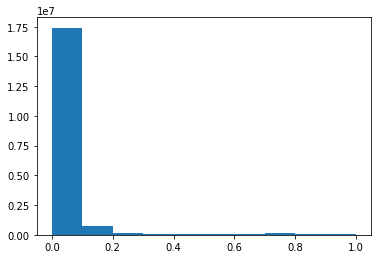

In [12]:
plt.hist(sub['is_attributed'])

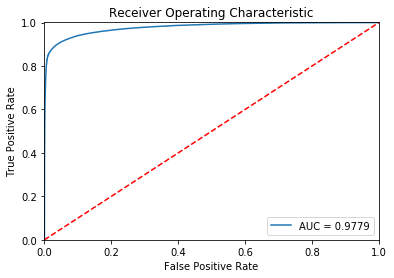

In [13]:

pred = model.predict(val_df, batch_size=batch_size)
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [14]:
print(thresholds)

[  1.99999368e+00   9.99993682e-01   9.99972105e-01 ...,   5.77545661e-13
   3.03255820e-13   7.75469437e-14]
